# Reproducing Power Spectra from Li et al. 2016
This workbook reproduces a few of the key figures from the Li et al. 2016
modeling the CO power spectrum at redshift ~2.5. It serves as both a validation
that the models implemented in SimIM work as expected and as a demonstration
of some modeling basics.

In [2]:
# Import basic libraries
import numpy as np
import matplotlib.pyplot as plt
from simim._pltsetup import pltdeco # For making plots look consistent
from simim import constants as sc

# Define some constants
sim_name = 'TNG100-3-Dark'
z_for_modeling = 2.4

wl_co10 = sc.c / sc.nu_co10 # m

## Download an Illustris Snapshot
We will use the TNG100-3-Dark snapshot for redshift 2.4 for this model. If 
it's not already downloaded, we can get this simulation with the following 
code.

In [3]:
import simim.siminterface as sim

cat = sim.illustris.illustris_catalogs(sim_name,'[YOUR ILLUSTRIS API KEY HERE]', snaps=29)
cat.download_meta(redownload=False)
cat.download(redownload=False)
cat.format(remake=False)

/Users/keenan/Dropbox/4_research/2.1_simim_release/simim/siminterface/illustris.py:494: UserWarning: illustris_catalogs is depricated, use IllustrisCatalogs instead
  warnings.warn("illustris_catalogs is depricated, use IllustrisCatalogs instead")
/Users/keenan/Dropbox/4_research/2.1_simim_release/simim/siminterface/illustris.py:414: UserWarning: Metadata appears to exist already
  warnings.warn("Metadata appears to exist already")
/Users/keenan/Dropbox/4_research/2.1_simim_release/simim/siminterface/illustris.py:355: UserWarning: Skipping snapshot 29 as it appears to exist already
  warnings.warn("Skipping snapshot {} as it appears to exist already".format(i))
/Users/keenan/Dropbox/4_research/2.1_simim_release/simim/siminterface/_rawsiminterface.py:461: UserWarning: No new data has been added to file
  warnings.warn("No new data has been added to file")


## Add SFR and CO Emission to the Cube
Next we add SFR's using the Behroozi et al. 2013 scaling relation, and
CO luminosities using the integrated KS law, as parameterized by Li et al.
We utilize pre-defined properties in SimIM to implement these scalings.

We will initially study produce a mock with no scatter in the $M_h$-SFR-$L_{\rm CO}$
scalings, in order to reproduce Figure 3 from the Li et al. paper.

In [4]:
# Initialize a handler for the formatted simulation and snapshot
from simim.siminterface import SimHandler

tng100 = SimHandler(sim_name)
tng100_z2p4 = tng100.get_snap_from_z(z_for_modeling)

# Apply the required properties
from simim.galprops import prop_li_co,prop_behroozi_sfr
from simim.map import Gridder

tng100_z2p4.set_property_range('mass',pmin=1e10,in_h_units=False)
tng100_z2p4.make_property(prop_behroozi_sfr,rename='sfr_behroozi',other_kws={'scatter':False})
tng100_z2p4.make_property(prop_li_co,rename='LCO_ns',kw_remap={'sfr':'sfr_behroozi'},other_kws={'scatter_lco':False})

We can reproduce Figure 2 from Li et al. 2016 showing the $M_h$-$L_{\rm CO}$ relation
this model creates. Note that not all models from the Li et al. plot are included and 
that we have added the Lidz et al. 2011 model.

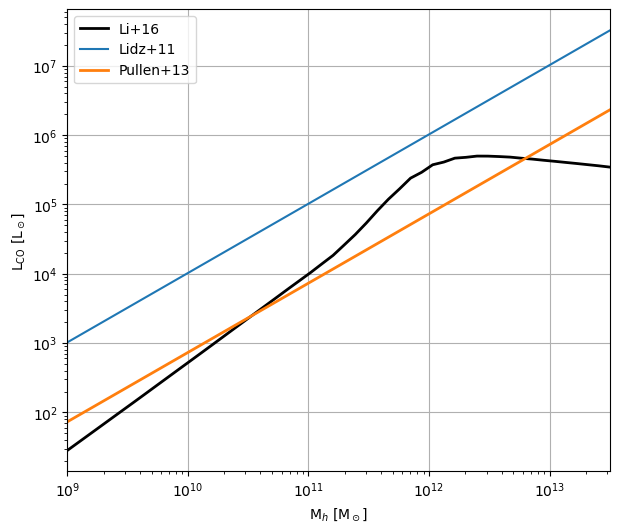

In [5]:
from simim.galprops.line_co import li16,lidz11,pullen13
from simim.galprops.sfr_behroozi13 import sfr as sfr_behroozi

msun = np.logspace(9,13.5)
sfr = sfr_behroozi(z_for_modeling,msun,scatter=False)
lco_li = li16(sfr,scatter_lco=False)

f_duty = .1/tng100_z2p4.cosmo.age(z_for_modeling).value
lco_lidz = lidz11(msun,f_duty,rand_f_duty=False)

lco_pullen = pullen13(msun,z_for_modeling,cosmo=tng100_z2p4.cosmo,rand_f_duty=False)

# Plot results
fig,ax = plt.subplots(figsize=(7,6))
ax.set(xlabel='M$_h$ [M$_\odot$]',ylabel='L$_\mathregular{CO}$ [L$_\odot$]',xscale='log',yscale='log',xlim=(1e9,10**13.5))
ax.grid()
ax.plot(msun,lco_li,lw=2,color='k',label='Li+16')
ax.plot(msun,lco_lidz,label='Lidz+11')
ax.plot(msun,lco_pullen,lw=2,label='Pullen+13')
ax.legend()
plt.show()



## Compute Intensities and Make a Cube
Next we retrieve the relevant halo properties, and use the distance
to our selected redshift along with the assigned CO luminosities
to compute CO intensities. 

We then put these intensities into a grid.

In [6]:
# Define a grid
pixel_size = tng100.box_edge_no_h / 100

# Compute some conversion factors from luminosity to brightness temperature
xfactor = tng100.cosmo.comoving_distance(z_for_modeling).value                         # Mpc / rad
yfactor = sc.nu_co10 * (1+z_for_modeling)**2 / (1000*tng100.cosmo.H(z_for_modeling).value)  # derivative of distance with respect to frequency in Mpc / Hz
dl = (1+z_for_modeling)*xfactor                               # luminosity distance to z in Mpc

# Convert flux to luminosity for each point
L_to_f = sc.Lsun_to_W / (4*np.pi*(dl*sc.Mpc_to_m)**2)         # Convert luminosity (Lsum) to flux (W/m^2)
f_to_i = xfactor**2*yfactor/pixel_size**3                     # Convert flux (W/m^2) to intensity (W/m^2/Str/Hz)
i_to_T = ((1+z_for_modeling)*wl_co10)**2 / (2*sc.kB) * 1e6    # Convert intensity (W/m^2/Str/Hz) to brightness temp (uK)
L_to_T = L_to_f * f_to_i * i_to_T

grid = tng100_z2p4.grid('LCO_ns',res=pixel_size,norm=L_to_T)
# temps = tng100.return_property('LCO_ns',in_h_units=False) * L_to_f * f_to_i * i_to_T

# # Get object positions
# x = tng100.return_property('pos_x',in_h_units=False)
# y = tng100.return_property('pos_y',in_h_units=False)
# z = tng100.return_property('pos_z',in_h_units=False)
# positions = np.array([x,y,z]).T

# # Make the grid
# grid = gridder(positions,temps,center_point=center_point,side_length=side_length,pixel_size=pixel_size,axunits='Mpc',gridunits='uK')

## Make a Power Spectrum
Now, we can use the grid to estimate a power spectrum. The resulting plot
can be compared to the fiducial power spectrum shown in Figure 3 of Li et al.
2016.

In [7]:
# Compute the power spectrum
ps = grid.power_spectrum(in_place=False,normalize=True)

In [10]:
# Spherical average
bins = np.logspace(-3,3,61)
bin_centers = np.logspace(-2.95,2.95,60)
_,ps1d = ps.spherical_average(ax=[0,1,2],shells=bins)
ps1d = ps1d[:,0] / np.prod(grid.side_length)  # Normalize by volume
k = 2*np.pi * bin_centers

/Users/keenan/Dropbox/4_research/2.1_simim_release/simim/map/gridder.py:1424: RuntimeWarning: invalid value encountered in divide
  binned_averages /= binned_weights


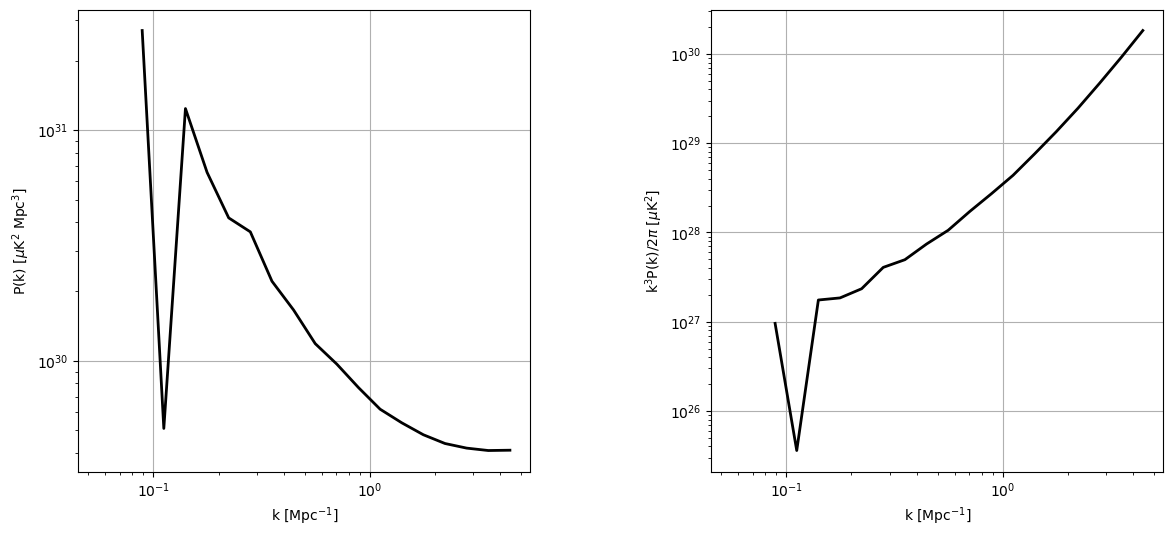

In [11]:
# Plot the results
fig,ax = plt.subplots(1,2,figsize=(14,6),sharex=True)
fig.subplots_adjust(wspace=.4)
ax[0].set(xlabel='k [Mpc$^{-1}$]',ylabel='P(k) [$\mu$K$^2$ Mpc$^{3}$]',xscale='log',yscale='log')
ax[0].grid()
ax[0].plot(k,ps1d,lw=2,color='k')
ax[1].set(xlabel='k [Mpc$^{-1}$]',ylabel='k$^3$P(k)/2$\pi$ [$\mu$K$^2$]',xscale='log',yscale='log')
ax[1].plot(k,k**3/2/np.pi**2*ps1d,lw=2,color='k')
ax[1].grid()
plt.show()


## Introduce Scatter to the Model
The Li et al. model allows for a scatter in the $M_h$-SFR and SFR-$L_{\rm CO}$ 
scaling relations. This results in increased shot noise in the final power
spectra. We can reproduce this result by creating a model with scatter and 
evaluating it many times.

In [9]:
n_draws = 100
bins = np.logspace(-3,3,61)
bin_centers = np.logspace(-2.95,2.95,60)
ps_1d_all = np.zeros((n_draws,60))

rng = np.random.default_rng(85712)

# Use larger pixels for faster processing
pixel_size_s = 1
side_length_s = ((simhandler.box_edge_no_h) // pixel_size_s) * pixel_size_s      # This crops the box to have an integer number of pixels
center_point_s = [side_length_s/2,side_length_s/2,side_length_s/2]
f_to_i_s = xfactor**2*yfactor/pixel_size_s**3                                    # Convert flux (W/m^2) to intensity (W/m^2/Str/Hz)

# Function to draw new SFR and LCO and compute the PS
def run_model_with_scatter():
    snap.make_property(prop_li_co,rename='LCO',kw_remap={'sfr':'sfr_behroozi'},other_kws={'scatter_lco':True,'sig_lco':0.37,'rng':rng},overwrite=True)
    temps_s = snap.return_property('LCO',in_h_units=False) * L_to_f * f_to_i_s * i_to_T
    grid_s = gridder(positions,temps_s,center_point=center_point_s,side_length=side_length_s,pixel_size=pixel_size_s,axunits='Mpc',gridunits='uK')
    ps_s = grid_s.power_spectrum(in_place=False,normalize=True)
    _,ps1d_s = ps_s.spherical_average(ax=[0,1,2],bins=bins)
    ps1d_s = ps1d_s[:,0] / side_length_s**3
    return ps1d_s

for i in range(n_draws):
    ps_1d_all[i] = run_model_with_scatter()
    print("Progress: {:.0f}%               ".format((i+1)/n_draws*100),end='\r')


/Users/rpkeenan/Dropbox/4_research/2.1_simim/simim/map/gridder.py:1008: RuntimeWarning: invalid value encountered in true_divide
  binned_averages /= binned_weights
/Users/rpkeenan/Dropbox/4_research/2.1_simim/simim/_handlers.py:248: UserWarning: Property LCO already exists, overwriting
  warnings.warn("Property {} already exists, overwriting".format(name))


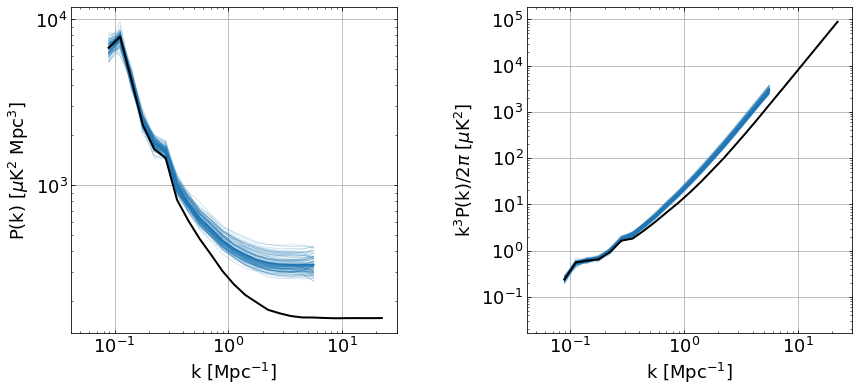

In [10]:
# Plot the results
fig,ax = plt.subplots(1,2,figsize=(14,6),sharex=True)
fig.subplots_adjust(wspace=.4)
ax[0].set(xlabel='k [Mpc$^{-1}$]',ylabel='P(k) [$\mu$K$^2$ Mpc$^{3}$]',xscale='log',yscale='log')
ax[0].grid()
ax[1].set(xlabel='k [Mpc$^{-1}$]',ylabel='k$^3$P(k)/2$\pi$ [$\mu$K$^2$]',xscale='log',yscale='log')
ax[1].grid()

for i in range(n_draws):
    ax[0].plot(k,ps_1d_all[i],lw=.75,alpha=.25,color='C0')
    ax[1].plot(k,k**3/2/np.pi**2*ps_1d_all[i],lw=.75,alpha=.25,color='C0')

ax[0].plot(k,np.mean(ps_1d_all,axis=0),lw=2,color='C0')
ax[1].plot(k,k**3/2/np.pi**2*np.mean(ps_1d_all,axis=0),lw=2,color='C0')
ax[0].plot(k,ps1d,lw=2,color='k')
ax[1].plot(k,k**3/2/np.pi**2*ps1d,lw=2,color='k')

plt.show()


## Compare Different Models
Li et al. consider a number of different parameter values for their SFR-$L_{\rm CO}$
relation, as well as other prescriptions for assigning line luminosities to halos.
We can reproduce those with relative ease:

In [11]:
# Run different parameter values for the SFR-LCO correlation:
alphas = [1.13,1.37,1.00,1.17,0.5,1.0,1.5,2.0]
betas = [0.53,-1.74,2.00,0.28,6.95,1.94,-3.07,-8.08]
names = ['d10','cw13','dz14','g14','1','2','3','4']

# Grid setup
pixel_size_ab = 1
side_length_ab = ((simhandler.box_edge_no_h) // pixel_size_ab) * pixel_size_ab      # This crops the box to have an integer number of pixels
center_point_ab = [side_length_ab/2,side_length_ab/2,side_length_ab/2]
f_to_i_ab = xfactor**2*yfactor/pixel_size_ab**3                                    # Convert flux (W/m^2) to intensity (W/m^2/Str/Hz)

ps1d_ab_vals = {}
for alpha, beta, name in zip(alphas,betas,names):
    snap.make_property(prop_li_co,rename='LCO_'+name,kw_remap={'sfr':'sfr_behroozi'},
                    other_kws={'scatter_lco':False,'a':alpha,'b':beta})

    temps_ab = snap.return_property('LCO_'+name,in_h_units=False) * L_to_f * f_to_i_ab * i_to_T
    grid_ab = gridder(positions,temps_ab,center_point=center_point_s,side_length=side_length_s,pixel_size=pixel_size_s,axunits='Mpc',gridunits='uK')
    ps_ab = grid_ab.power_spectrum(in_place=True,normalize=True)
    _,ps1d_ab = ps_ab.spherical_average(ax=[0,1,2],bins=bins)
    ps1d_ab_vals[name] = ps1d_ab[:,0] / side_length_ab**3

/Users/rpkeenan/Dropbox/4_research/2.1_simim/simim/map/gridder.py:1008: RuntimeWarning: invalid value encountered in true_divide
  binned_averages /= binned_weights


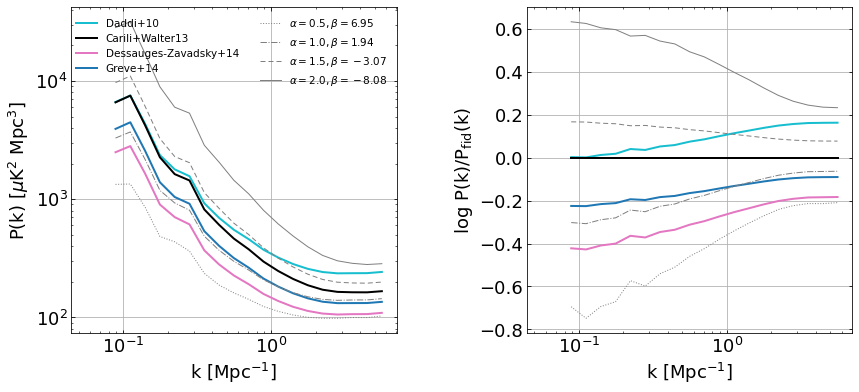

In [12]:
# Plot the results - compare to Li et al. 2016 Figure 6
fig,ax = plt.subplots(1,2,figsize=(14,6),sharex=True)
fig.subplots_adjust(wspace=.4)
ax[0].set(xlabel='k [Mpc$^{-1}$]',ylabel='P(k) [$\mu$K$^2$ Mpc$^{3}$]',xscale='log',yscale='log')
ax[0].grid()
ax[1].set(xlabel='k [Mpc$^{-1}$]',ylabel='log P(k)/P$_\mathregular{fid}$(k)',xscale='log',yscale='linear')
ax[1].grid()

names = ['d10','cw13','dz14','g14','1','2','3','4']
labels = ['Daddi+10','Carili+Walter13','Dessauges-Zavadsky+14','Greve+14',r'$\alpha=0.5,\beta=6.95$',r'$\alpha=1.0,\beta=1.94$',r'$\alpha=1.5,\beta=-3.07$',r'$\alpha=2.0,\beta=-8.08$',]
colors = ['C9','k','C6','C0','.5','.5','.5','.5']
lines = ['-','-','-','-',':','-.','--','-']
linewidths = [2,2,2,2,1,1,1,1]

for name,label,color,line,lw in zip(names,labels,colors,lines,linewidths):
    ax[0].plot(k,ps1d_ab_vals[name],lw=lw,color=color,ls=line,label=label)
    ax[1].plot(k,np.log10(ps1d_ab_vals[name]/ps1d_ab_vals['cw13']),lw=lw,color=color,ls=line,label=label)

ax[0].legend(fontsize='xx-small',ncol=2)
plt.show()
